## Utilization Prediction

### Import Libraries

In [17]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Import Data

In [4]:
charging_sessions_data = pd.read_csv("cleaned_data.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

charging_sessions_data.head(5)

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,connectionTime_local,disconnectTime_local,doneChargingTime_local,WhPerMile,kWhRequested,milesRequested,minutesAvailable,requestedDeparture
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,333,16.65,50,191,"Tue, 02 Jul 2019 01:47:08 GMT"
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,333,16.65,50,191,"Tue, 02 Jul 2019 01:47:08 GMT"
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,333,16.65,50,191,"Tue, 02 Jul 2019 01:47:08 GMT"
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,333,16.65,50,191,"Tue, 02 Jul 2019 01:47:08 GMT"
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,333,16.65,50,191,"Tue, 02 Jul 2019 01:47:08 GMT"


### Developing Prediction Model on hourly Utilization -> connectiontime to disconnectiontime in hours
1. **Feature Engineering** 
* normalisieren/skalieren - Angela
* enkodieren (kategorische Werte in numerische Werte umwandeln) - Coco
* Features bestimmen (Korrelation) - Marietta
2. **Find Optimal Machine Learning Method**
* Test different ML methods and evaluate them based on one metrics
    * Polynomial Regression - Simon
    * Random Forest - Angela
    * Lasso Regression - Simon
    * Ridge Regression - Marietta
    * neural network  - Coco
* Choose the ML methods demonstrating the best performance
3. **Developing Predictive Models**
* Prediction models are developed for its charging site
* Develop predictive model using neural networks
* Develop predictive model using any other machine learning methods of choice (see Section 1.)
* Use cross-validation to train the models
* Compare predictive performance of both models on the same holdout set
* Determine the type of model the operator should employ
4. **Examples for Business Case**
* Visualize data prediction to support/ enables business case
* Make example predictions to support/ enables business case

### 1.2 Feature Encoding

In [5]:
charging_sessions_data["connectionTime"] = pd.to_datetime(charging_sessions_data["connectionTime"])
charging_sessions_data["disconnectTime"] = pd.to_datetime(charging_sessions_data["disconnectTime"])
charging_sessions_data["doneChargingTime"] = pd.to_datetime(charging_sessions_data["doneChargingTime"])
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"])
# Encoding weekday 
weather_data["is_weekday"] = np.where(weather_data['timestamp'].dt.weekday.isin([5, 6]), 0, 1)
charging_sessions_data["is_weekday"] = np.where(charging_sessions_data['connectionTime'].dt.weekday.isin([5, 6]), 0, 1)

# Extract hour and month
weather_data["month"] = weather_data['timestamp'].dt.month
weather_data["hour"] = weather_data['timestamp'].dt.hour
charging_sessions_data["month"] = charging_sessions_data['connectionTime'].dt.month
charging_sessions_data["hour"] = charging_sessions_data['connectionTime'].dt.hour

# Encoding hour by Sin-Cos Encoding
weather_data['hour_sin'] = np.sin(2 * np.pi * weather_data['hour'] / 24)
weather_data['hour_cos'] = np.cos(2 * np.pi * weather_data['hour'] / 24)


charging_sessions_data['hour_sin'] = np.sin(2 * np.pi * charging_sessions_data['hour'] / 24)
charging_sessions_data['hour_cos'] = np.cos(2 * np.pi * charging_sessions_data['hour'] / 24)

# Encoding month by Sin-Cos Encoding
weather_data['month_sin'] = np.sin(2 * np.pi * weather_data['month'] / 12)
weather_data['month_cos'] = np.cos(2 * np.pi * weather_data['month'] / 12)

charging_sessions_data['month_sin'] = np.sin(2 * np.pi * charging_sessions_data['month'] / 12)
charging_sessions_data['month_cos'] = np.cos(2 * np.pi * charging_sessions_data['month'] / 12)

In [6]:
# Lets group the table by month, hour and weekday to later join it in the charging data
# Therefore other attributes have to be averaged 
grouped_weather = weather_data.groupby(['month', 'is_weekday', 'hour']).agg({
    'temperature': 'mean',   # Average temperature
    'precipitation': 'max',      # maximum precipitation
    'windspeed': 'mean'     # EAverage wind speed
}).reset_index()
grouped_weather.rename(columns = {"temperature" : "avg_temperature", "precipitation": "max__precipitation","windspeed":"avg_windspeed"}, inplace = True)
result = grouped_weather.merge(weather_data, how = "outer",on = ["month", "is_weekday", "hour"] )
grouped_weather
result

,month,is_weekday,hour,avg_temperature,max__precipitation,avg_windspeed,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature,hour_sin,hour_cos,month_sin,month_cos
0,1,0,0,17.640000,1.27,8.840000,Burbank,2018-01-06 00:53:00,19.0,26.0,Cloudy,992.73,7.0,0.00,19.0,0.000000,1.000000,5.000000e-01,0.866025
1,1,0,0,17.640000,1.27,8.840000,Burbank,2018-01-07 00:53:00,18.0,34.0,Fair,990.43,6.0,0.00,18.0,0.000000,1.000000,5.000000e-01,0.866025
2,1,0,0,17.640000,1.27,8.840000,Burbank,2018-01-13 00:53:00,22.0,30.0,Partly Cloudy,990.43,0.0,0.00,22.0,0.000000,1.000000,5.000000e-01,0.866025
3,1,0,0,17.640000,1.27,8.840000,Burbank,2018-01-14 00:53:00,26.0,30.0,Partly Cloudy,990.10,6.0,0.00,26.0,0.000000,1.000000,5.000000e-01,0.866025
4,1,0,0,17.640000,1.27,8.840000,Burbank,2018-01-20 00:22:00,14.0,26.0,Cloudy,984.50,19.0,0.00,14.0,0.000000,1.000000,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29239,12,1,23,17.347222,3.30,11.083333,Burbank,2020-12-28 23:17:00,8.0,40.0,Heavy Rain,982.86,17.0,0.51,6.0,-0.258819,0.965926,-2.449294e-16,1.000000
29240,12,1,23,17.347222,3.30,11.083333,Burbank,2020-12-28 23:53:00,8.0,11.0,Light Rain,983.19,0.0,3.30,8.0,-0.258819,0.965926,-2.449294e-16,1.000000
29241,12,1,23,17.347222,3.30,11.083333,Burbank,2020-12-29 23:53:00,16.0,34.0,Fair,991.75,26.0,0.00,16.0,-0.258819,0.965926,-2.449294e-16,1.000000
29242,12,1,23,17.347222,3.30,11.083333,Burbank,2020-12-30 23:53:00,18.0,34.0,Fair,992.41,9.0,0.00,18.0,-0.258819,0.965926,-2.449294e-16,1.000000


### 1.3 Determining Features (Correlation)

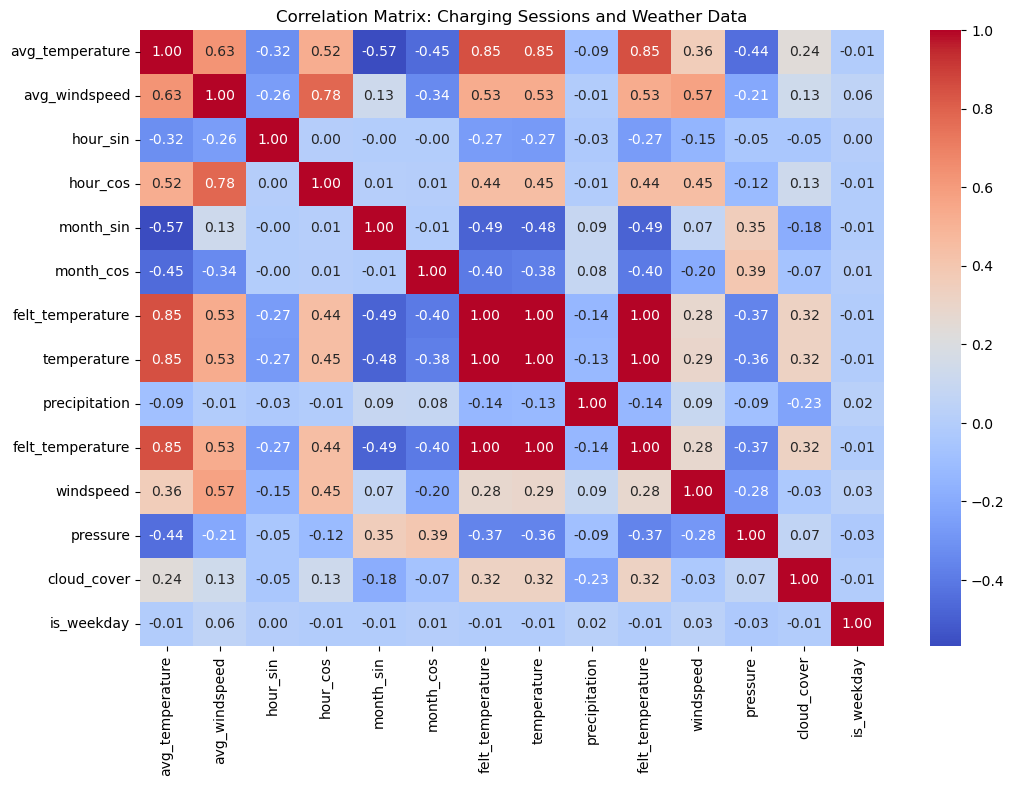

In [16]:

# choice of relecant numeric features 
correlation_features = [
    'avg_temperature', 'avg_windspeed', 'hour_sin', 'hour_cos', 
    'month_sin', 'month_cos', 'felt_temperature', 'temperature', 'precipitation',
    'felt_temperature', 'windspeed', 'pressure', 'cloud_cover', 'is_weekday'
]

# calculate the correlation 
correlation_matrix = result[correlation_features].corr()

# plot a heatmap of the correlation 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Charging Sessions and Weather Data')
plt.show()

### 2. Find Optimal Machine Learning Method

#### 2.1 Polynomial Regression

#### 2.2 Random Forest

#### 2.3 Lasso Regression

#### 2.4 Ridge Regression

In [ ]:
# count the stations for each siteID 
stations_per_site = charging_sessions_data.groupby('siteID')['stationID'].nunique().reset_index()
stations_per_site.rename(columns={'stationID': 'total_stations'}, inplace=True)

print(stations_per_site)

   siteID  total_stations
0       1              52
1       2              54


In [39]:
# Calculate the duration of each session
charging_sessions_data['connectionTime'] = pd.to_datetime(charging_sessions_data['connectionTime'])
charging_sessions_data['disconnectTime'] = pd.to_datetime(charging_sessions_data['disconnectTime'])
charging_sessions_data['duration'] = (charging_sessions_data['disconnectTime'] - charging_sessions_data['connectionTime']).dt.total_seconds() / 3600  # Dauer in Stunden

# Summarise the loading times per hour and site
hourly_utilization = charging_sessions_data.groupby(['connectionTime', 'siteID']).agg(
    active_time=('duration', 'sum'),  # Summe der Ladezeit in Stunden
).reset_index()

# Add the total number of stations for each site
hourly_utilization = hourly_utilization.merge(stations_per_site, on='siteID', how='left')

# Calculate the utilization per hour
hourly_utilization['utilization'] = hourly_utilization['active_time'] / (hourly_utilization['total_stations'] * (hourly_utilization['connectionTime'].dt.hour + 1))

# Check the first five results
print(hourly_utilization.head())

             connectionTime  siteID  active_time  total_stations  utilization
0 2018-04-25 13:45:10+00:00       2    11.185000              54     0.014795
1 2018-04-25 13:45:50+00:00       2     9.315278              54     0.012322
2 2018-04-25 14:37:06+00:00       2     9.307778              54     0.011491
3 2018-04-25 14:40:34+00:00       2     8.377222              54     0.010342
4 2018-04-25 14:43:50+00:00       2    10.561111              54     0.013038


#### 2.5 Neural Network

### 3. Developing Predictive Models

#### 3.1. Train Models

#### 3.2. Cross-Validation

#### 3.3. Performance Evaluation

### 4. Examples for Business Case

#### 4.1. Visualizing Prediction Data

#### 4.2. Example Prediction